In [5]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
blobs = pd.read_csv('kmeans_blobs.csv')
colnames = list(blobs.columns[1:-1])
blobs.head()

,ID,x,y,cluster
0,0,24.412,32.932,2
1,1,35.190,12.189,1
2,2,26.288,41.718,2
3,3,0.376,15.506,0
4,4,26.116,3.963,1


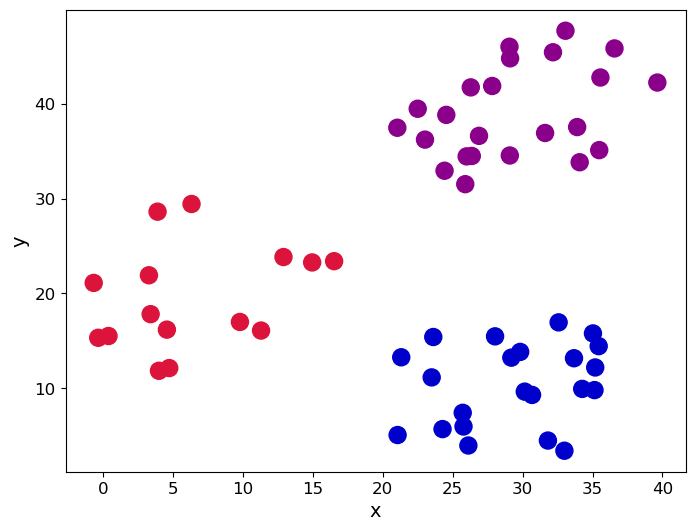

In [9]:
customcmap = ListedColormap(["crimson","mediumblue","darkmagenta"])
fig, ax = plt.subplots(figsize=(8,6))
plt.scatter(x=blobs['x'], y=blobs['y'], s=150,
            c=blobs['cluster'].astype('category'),
            cmap = customcmap)
ax.set_xlabel(r'x', fontsize=14)
ax.set_ylabel(r'y', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Steps 1 & 2 - Define k and initiate the centroids

In [10]:
def initiate_centroids(k, dset):
    """
    Select k data points as centroids
    k: number of centroids
    dset: pandas dataframe
    """
    centroids = dset.sample(k)
    return centroids


np.random.seed(42)
k = 3
df = blobs[["x", "y"]]
centroids = initiate_centroids(k, df)
centroids

,x,y
0,24.412,32.932
5,25.893,31.515
36,26.878,36.609


## Step 3 - Calculate distance

In [11]:
def rsserr(a, b):
    """
    Calculate the root of sum of squared errors.
    a and b are numpy arrays
    """
    return np.square(np.sum((a - b) ** 2))

In [13]:
for i, centroid in enumerate(range(centroids.shape[0])):
    err = rsserr(centroids.iloc[centroid,:], df.iloc[36,:])
    print('Error for centroid {0}: {1:.2f}'.format(i, err))
    

Error for centroid 0: 384.22
Error for centroid 1: 724.64
Error for centroid 2: 0.00


## Step 4 - Assign centroids

In [14]:
def centroid_assignation(dset, centroids):
    """
    Given a dataframe `dset` and a set of `centroids`, we assign each
    data point in `dset` to a centroid.
    - dset - pandas dataframe with observations
    - centroids - pa das dataframe with centroids
    """
    k = centroids.shape[0]
    n = dset.shape[0]
    assignation = []
    assign_errors = []

    for obs in range(n):
        # Estimate error
        all_errors = np.array([])
        for centroid in range(k):
            err = rsserr(centroids.iloc[centroid, :], dset.iloc[obs, :])
            all_errors = np.append(all_errors, err)

        # Get the nearest centroid and the error
        nearest_centroid = np.where(all_errors == np.amin(all_errors))[0].tolist()[0]
        nearest_centroid_error = np.amin(all_errors)

        # Add values to corresponding lists
        assignation.append(nearest_centroid)
        assign_errors.append(nearest_centroid_error)

    return assignation, assign_errors

In [15]:
df["centroid"], df["error"] = centroid_assignation(df, centroids)
df.head()

/var/folders/8_/wmggdyf5497bw9n_2zgn9kzh0000gn/T/ipykernel_20385/53873462.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["centroid"], df["error"] = centroid_assignation(df, centroids)


,x,y,centroid,error
0,24.412,32.932,0,0.000000
1,35.190,12.189,1,211534.211314
2,26.288,41.718,2,699.601495
3,0.376,15.506,0,776856.744109
4,26.116,3.963,1,576327.599678


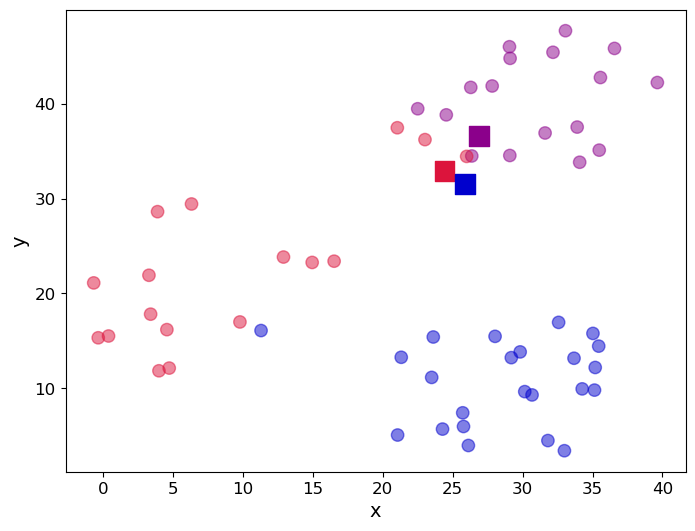

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(
    df.iloc[:, 0],
    df.iloc[:, 1],
    marker="o",
    c=df["centroid"].astype("category"),
    cmap=customcmap,
    s=80,
    alpha=0.5,
)
plt.scatter(
    centroids.iloc[:, 0],
    centroids.iloc[:, 1],
    marker="s",
    s=200,
    c=[0, 1, 2],
    cmap=customcmap,
)
ax.set_xlabel(r"x", fontsize=14)
ax.set_ylabel(r"y", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [17]:
print("The total error is {0:.2f}".format(df['error'].sum()))


The total error is 11927659.01


## Step 5 - Update centroid location

In [18]:
centroids = df.groupby("centroid").agg("mean").loc[:, colnames].reset_index(drop=True)
centroids

,x,y
0,9.889444,23.242611
1,28.435750,11.546250
2,30.759333,40.311167


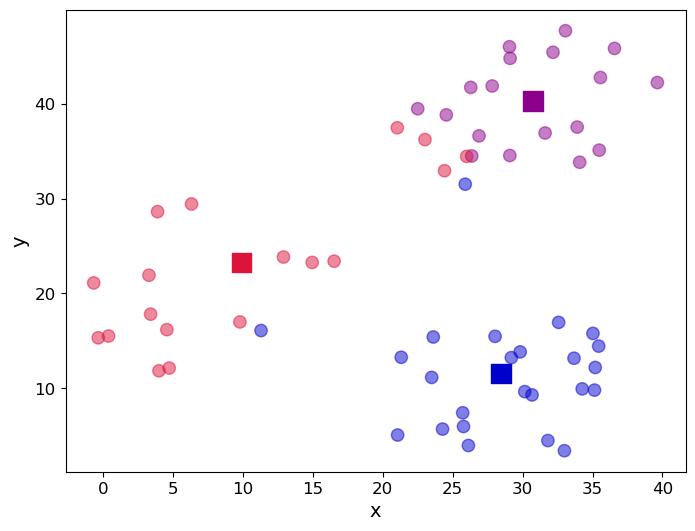

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(
    df.iloc[:, 0],
    df.iloc[:, 1],
    marker="o",
    c=df["centroid"].astype("category"),
    cmap=customcmap,
    s=80,
    alpha=0.5,
)
plt.scatter(
    centroids.iloc[:, 0],
    centroids.iloc[:, 1],
    marker="s",
    s=200,
    c=[0, 1, 2],
    cmap=customcmap,
)
ax.set_xlabel(r"x", fontsize=14)
ax.set_ylabel(r"y", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Step 6 - Repeat steps 3-5

In [30]:
def kmeans(dset, k=2, tol=1e-4):
    """
    K-means implementationd for a
    `dset`:  DataFrame with observations
    `k`: number of clusters, default k=2
    `tol`: tolerance=1E-4
    """
    # Let us work in a copy, so we don't mess the original
    working_dset = dset.copy()
    # We define some variables to hold the error, the
    # stopping signal and a counter for the iterations
    err = []
    goahead = True
    j = 0

    # Step 2: Initiate clusters by defining centroids
    centroids = initiate_centroids(k, dset)

    while goahead:
        # Step 3 and 4 - Assign centroids and calculate error
        working_dset["centroid"], j_err = centroid_assignation(working_dset, centroids)
        err.append(sum(j_err))

        # Step 5 - Update centroid position
        centroids = working_dset.groupby("centroid").agg("mean").reset_index(drop=True)

        # Step 6 - Restart the iteration
        if j > 0:
            # Is the error less than a tolerance (1E-4)
            if err[j - 1] - err[j] <= tol:
                goahead = False
        j += 1

    working_dset["centroid"], j_err = centroid_assignation(working_dset, centroids)
    centroids = working_dset.groupby("centroid").agg("mean").reset_index(drop=True)
    return working_dset["centroid"], j_err, centroids

In [31]:
np.random.seed(42)
df["centroid"], df["error"], centroids = kmeans(df[["x", "y"]], 3)
df.head()

,x,y,centroid,error
0,24.412,32.932,2,3767.568743
1,35.190,12.189,1,1399.889001
2,26.288,41.718,2,262.961097
3,0.376,15.506,0,2683.086425
4,26.116,3.963,1,2723.650198


In [32]:
centroids

,x,y
0,6.322867,19.559800
1,29.330864,10.432409
2,29.304957,39.050783


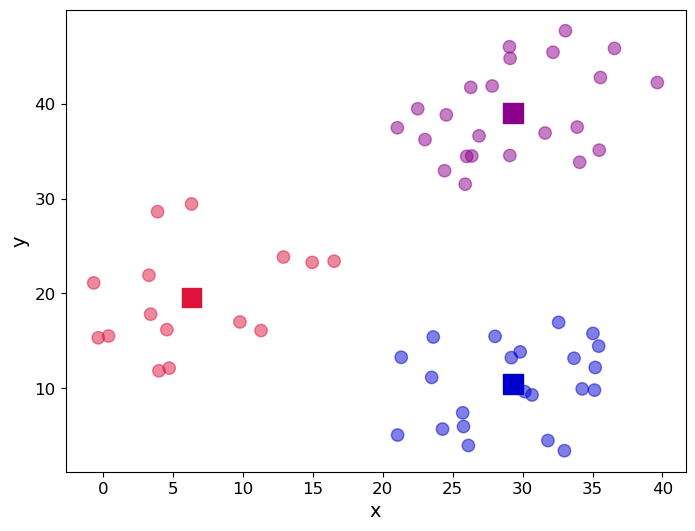

In [33]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(
    df.iloc[:, 0],
    df.iloc[:, 1],
    marker="o",
    c=df["centroid"].astype("category"),
    cmap=customcmap,
    s=80,
    alpha=0.5,
)
plt.scatter(
    centroids.iloc[:, 0],
    centroids.iloc[:, 1],
    marker="s",
    s=200,
    c=[0, 1, 2],
    cmap=customcmap,
)
ax.set_xlabel(r"x", fontsize=14)
ax.set_ylabel(r"y", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

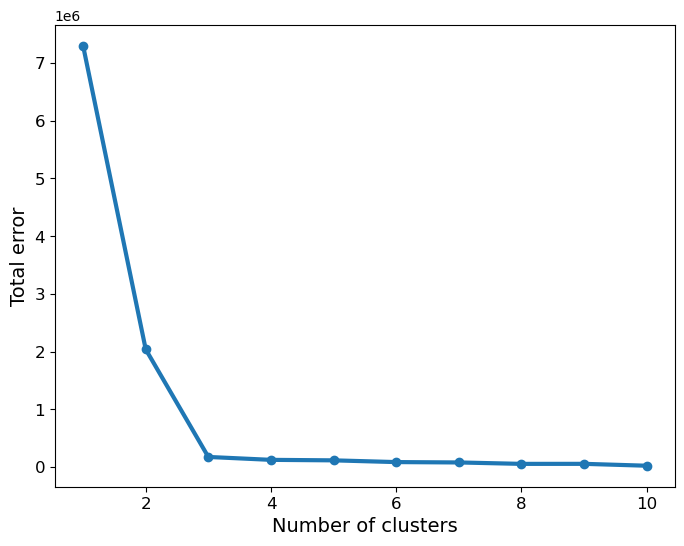

In [25]:
err_total = []
n = 10

df_elbow = blobs[["x", "y"]]

for i in range(n):
    _, my_errs, _ = kmeans(df_elbow, i + 1)
    err_total.append(sum(my_errs))
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(range(1, n + 1), err_total, linewidth=3, marker="o")
ax.set_xlabel(r"Number of clusters", fontsize=14)
ax.set_ylabel(r"Total error", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()